# Gold recovery or rush? You decide
Zyfra develops efficiency solutions for heavy industry. We are preparing a prototype of a machine learning model for them. We will prepare the data, perform an analysis, and then develop and train a model. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

In [2]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
full = pd.read_csv('/datasets/gold_recovery_full.csv')

## Train

In [3]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


None

## Test

In [4]:
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

None

## Full

In [5]:
display(full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


None

In [6]:
print(train.duplicated().sum())
print(test.duplicated().sum())
print(full.duplicated().sum())

0
0
0


The train dataset has 87 columns and over 16,000 entries. There are 0 duplicates and most of the datatypes are floats.

The test dataset has 53 columns and almost 6,000 entries. There are 0 duplicates and most of the datatypes are floats. 

The full dataset has 87 columns and nearly 23,000 entries. There are also 0 duplicates and the datatypes are also floats.

## Calculate missing value percentage

In [7]:
# Define function to calculate missing values percentage
def calculate_missing_values(df):
    missing_values = df.isnull().sum()
    total_values = np.product(df.shape)
    missing_percent = (missing_values / total_values) * 100
    return missing_percent

# Calculate missing values percentage for each dataset
missing_percent_train = calculate_missing_values(train)
missing_percent_test = calculate_missing_values(test)
missing_percent_full = calculate_missing_values(full)

print("Missing values percentage in training dataset:\n", missing_percent_train)
print("\nMissing values percentage in test dataset:\n", missing_percent_test)
print("\nMissing values percentage in full dataset:\n", missing_percent_full)

Missing values percentage in training dataset:
 date                                          0.000000
final.output.concentrate_ag                   0.004909
final.output.concentrate_pb                   0.004909
final.output.concentrate_sol                  0.025225
final.output.concentrate_au                   0.004840
                                                ...   
secondary_cleaner.state.floatbank5_a_level    0.005795
secondary_cleaner.state.floatbank5_b_air      0.005795
secondary_cleaner.state.floatbank5_b_level    0.005727
secondary_cleaner.state.floatbank6_a_air      0.007022
secondary_cleaner.state.floatbank6_a_level    0.005795
Length: 87, dtype: float64

Missing values percentage in test dataset:
 date                                          0.000000
primary_cleaner.input.sulfate                 0.097304
primary_cleaner.input.depressant              0.091504
primary_cleaner.input.feed_size               0.000000
primary_cleaner.input.xanthate                0.053485


We are identifying the extent of missing data in our datasets. By doing so, it will help us understand how crucial the percentage of missing values is and help us handle missing values in our analysis.

## Prepare the data

### Check recovery calculations

In [8]:
# Clean the dataset by dropping rows with missing values needed for the calculation
train = train.dropna(subset=['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery'])

# Extract the necessary columns for recovery calculation
C = train['rougher.output.concentrate_au']
F = train['rougher.input.feed_au']
T = train['rougher.output.tail_au']

# Calculate recovery using the formula
calculated_recovery = (C * (F - T)) / (F * (C - T)) * 100

# Calculate Mean Absolute Error between the calculated recovery and the actual 'rougher.output.recovery' feature
actual_recovery = train['rougher.output.recovery']
mae_recovery = mean_absolute_error(actual_recovery, calculated_recovery)

# Print the MAE result
mae_recovery

9.303415616264301e-15

We cleaned the dataset, calculate the recovery of valuable material in a mining process, and assess the accuracy of these calculations by comparing them to actual recorded recovery values using MAE. This validation step is crucial for ensuring the reliability of the recovery calculations that may be used in further analysis or modeling.

### Analyze features not available in the test set

In [9]:
# Get columns in the training set but not in the test set
missing_in_test = set(train.columns) - set(test.columns)
display("Missing features in test set:", missing_in_test)

'Missing features in test set:'

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

We highlighted any differences in features between the training and test datasets. Identifying these missing features is essential for ensuring the integrity of your machine learning workflow and avoiding potential issues during model evaluation.

### Perform data processing

In [10]:
# Fill missing values for both train and test datasets using forward and backward fill
train_data_filled = train.fillna(method='ffill').fillna(method='bfill').fillna(train.median())
test_data_filled = test.fillna(method='ffill').fillna(method='bfill').fillna(test.median())

# Replace positive and negative infinity with a large finite number
train = train.replace([np.inf, -np.inf], np.finfo('float32').max)
test = test.replace([np.inf, -np.inf], np.finfo('float32').max)

# Convert only numeric columns to float32
numeric_columns = train.select_dtypes(include=['float64', 'int64']).columns
train[numeric_columns] = train[numeric_columns].astype('float32')

numeric_columns_test = test.select_dtypes(include=['float64', 'int64']).columns
test[numeric_columns_test] = test[numeric_columns_test].astype('float32')

# Define train_data_aligned and test_data_aligned after filling NaN values
train_data_aligned = train_data_filled
test_data_aligned = test_data_filled

# Align features for training and test datasets by finding common columns
common_columns_for_model = train_data_aligned.drop(columns=['date']).columns.intersection(test_data_aligned.columns)

# Create train and test features based on common columns
train_features = train_data_aligned[common_columns_for_model]
test_features = test_data_aligned[common_columns_for_model]

# Set features for the train_test_split
features = train_features

# Set target variables
target_rougher = train['rougher.output.recovery']
target_final = train['final.output.recovery']

We performed comprehensive preprocessing steps to clean and prepare the training and test datasets.

## Analyze the data

### Concentration of metals at different stages

In [11]:
metals = ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb',
          'rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']
display(train[metals].describe())

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.output.concentrate_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb
count,14287.000000,14287.000000,14164.000000,14287.000000,14287.000000,14287.000000
mean,7.840161,8.561742,3.516450,19.399651,11.757778,7.649529
std,1.951916,1.910018,1.078211,3.858091,2.783937,1.890110
min,0.010000,0.010000,0.008001,0.000000,0.000000,0.000000
25%,6.582628,7.123781,2.775010,18.398076,10.474166,6.842347
50%,7.637921,8.145010,3.418776,19.942364,11.743756,7.756204
75%,9.052151,9.905030,4.223256,21.391149,13.432909,8.601422
max,13.126042,14.596026,7.142594,28.522810,24.480270,18.394041


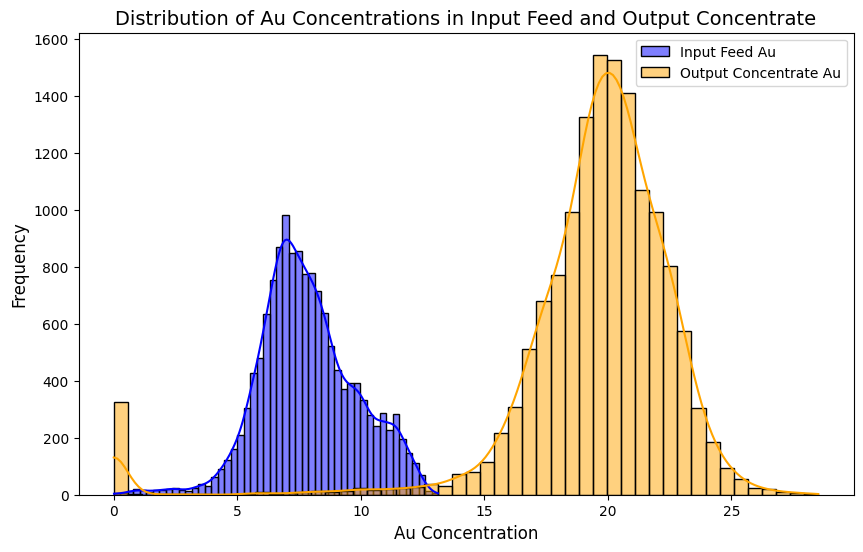

In [12]:
au_columns = ['rougher.input.feed_au', 'rougher.output.concentrate_au']
plt.figure(figsize=(10, 6))

# Plot distribution for 'rougher.input.feed_au' 
sns.histplot(train['rougher.input.feed_au'], bins=50, kde=True, color='blue', label='Input Feed Au')

# Plot distribution for 'rougher.output.concentrate_au' 
sns.histplot(train['rougher.output.concentrate_au'], bins=50, kde=True, color='orange', label='Output Concentrate Au')

plt.title('Distribution of Au Concentrations in Input Feed and Output Concentrate', fontsize=14)
plt.xlabel('Au Concentration', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

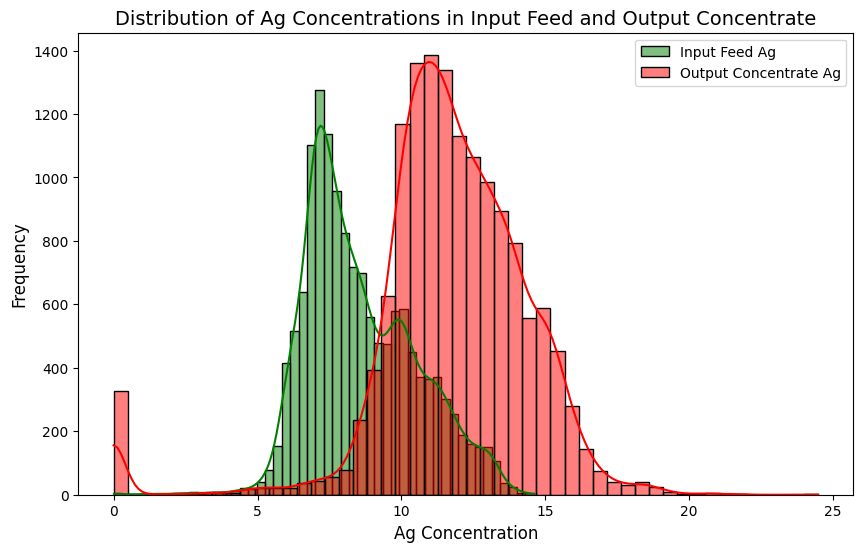

In [13]:
ag_columns = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag']
plt.figure(figsize=(10, 6))

# Plot distribution for 'rougher.input.feed_ag' 
sns.histplot(train['rougher.input.feed_ag'], bins=50, kde=True, color='green', label='Input Feed Ag')

# Plot distribution for 'rougher.output.concentrate_ag' 
sns.histplot(train['rougher.output.concentrate_ag'], bins=50, kde=True, color='red', label='Output Concentrate Ag')

plt.title('Distribution of Ag Concentrations in Input Feed and Output Concentrate', fontsize=14)
plt.xlabel('Ag Concentration', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

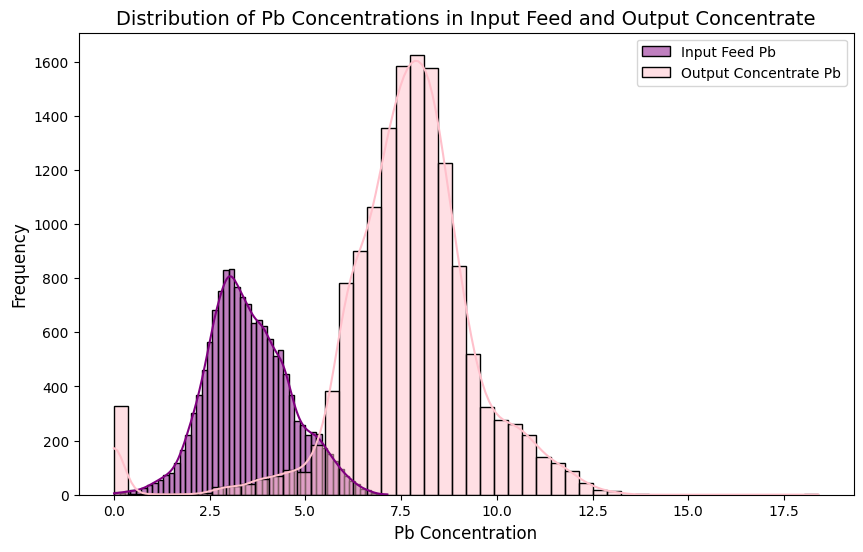

In [14]:
pb_columns = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb']
plt.figure(figsize=(10, 6))

# Plot distribution for 'rougher.input.feed_pb' 
sns.histplot(train['rougher.input.feed_pb'], bins=50, kde=True, color='purple', label='Input Feed Pb')

# Plot distribution for 'rougher.output.concentrate_pb' 
sns.histplot(train['rougher.output.concentrate_pb'], bins=50, kde=True, color='pink', label='Output Concentrate Pb')

plt.title('Distribution of Pb Concentrations in Input Feed and Output Concentrate', fontsize=14)
plt.xlabel('Pb Concentration', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

TThe distributions of metal concentrations for Au, Ag, and Pb demonstrate a clear trend of increasing levels throughout the purification stages.

Gold (Au) exhibits the most pronounced and efficient increase in concentration, with distinct peaks at each stage. The final concentrate shows the highest concentration, reflecting an effective recovery process.
Silver (Ag) and Lead (Pb) also display improvements in concentration during the stages, but their distributions are wider. This indicates that while the purification process is effective, it is less efficient compared to the recovery of gold.

In conclusion, the metal concentration distributions suggest that the purification process is highly effective for gold, with noticeable increases in silver and lead concentrations, albeit to a lesser extent.he metal concentration distributions suggest that the purification process is highly effective for gold, with noticeable increases in silver and lead concentrations, albeit to a lesser extent.

### Compare feed particle size distributions

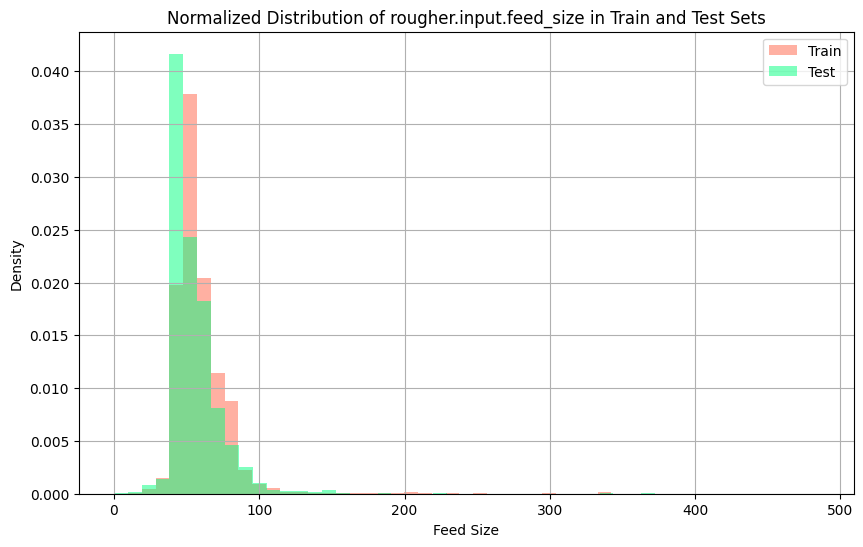

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(train['rougher.input.feed_size'], bins=50, alpha=0.5, label='Train', color='tomato', density=True)
plt.hist(test['rougher.input.feed_size'], bins=50, alpha=0.5, label='Test', color='springgreen', density=True)
plt.title('Normalized Distribution of rougher.input.feed_size in Train and Test Sets')
plt.xlabel('Feed Size')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

After normalizing the histograms, it is evident that the feed particle size distributions in both the training and test sets are quite comparable. The highest density for both distributions occurs between 50 and 100 feed size units.

Overall, the similarity between the two distributions indicates that the model trained on the training set is likely to generalize effectively to the test set concerning feed particle size.

### Total concentration of substances

In [16]:
# Raw feed stage 
train['total_feed'] = (train['rougher.input.feed_au'] + 
                            train['rougher.input.feed_ag'] + 
                            train['rougher.input.feed_pb'])

# Rougher concentrate stage 
train['total_rougher_concentrate'] = (train['rougher.output.concentrate_au'] + 
                                           train['rougher.output.concentrate_ag'] + 
                                           train['rougher.output.concentrate_pb'])

# Final concentrate stage 
train['total_final_concentrate'] = (train['final.output.concentrate_au'] + 
                                         train['final.output.concentrate_ag'] + 
                                         train['final.output.concentrate_pb'])

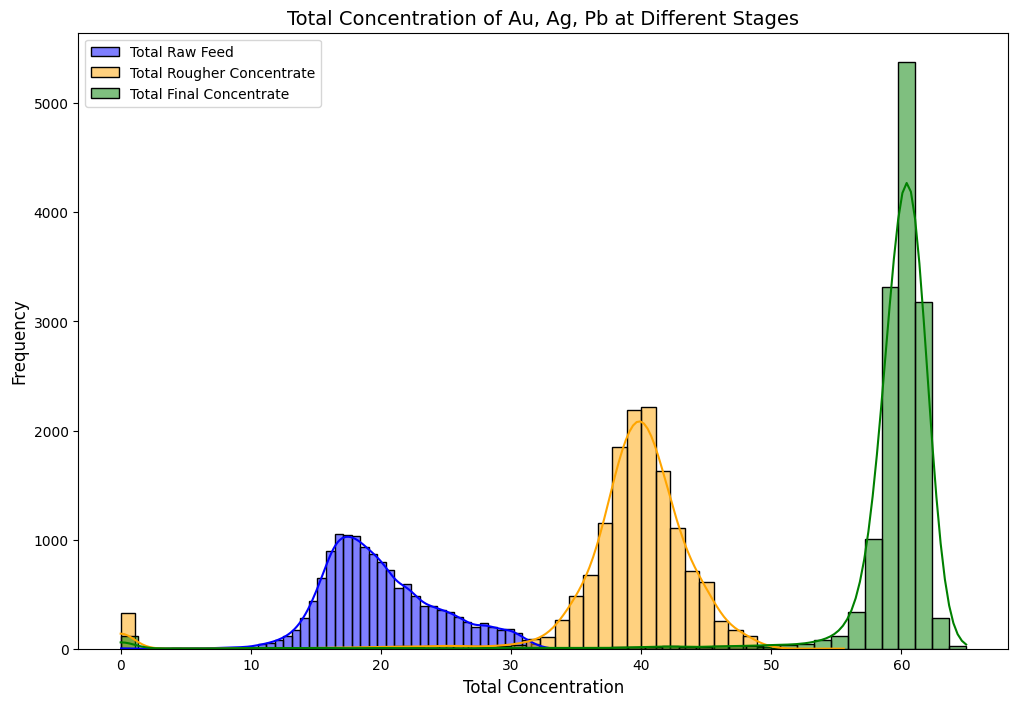

In [17]:
plt.figure(figsize=(12, 8))

# Plot the distribution for total concentrations in raw feed, rougher concentrate, and final concentrate
sns.histplot(train['total_feed'], bins=50, kde=True, color='blue', label='Total Raw Feed')
sns.histplot(train['total_rougher_concentrate'], bins=50, kde=True, color='orange', label='Total Rougher Concentrate')
sns.histplot(train['total_final_concentrate'], bins=50, kde=True, color='green', label='Total Final Concentrate')

plt.title('Total Concentration of Au, Ag, Pb at Different Stages', fontsize=14)
plt.xlabel('Total Concentration', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

We conducted an analysis of the total concentrations of Au, Ag, and Pb across various stages: raw feed, rougher concentrate, and final concentrate. Some extreme values observed in the final concentrate stage raised concerns about potential outliers. Further investigation revealed rows with near-zero total concentrations at different stages, likely abnormalities, as it is highly unlikely for metal concentrations to be near zero during any recovery process stage. By filtering out rows with near-zero concentrations, we have enhanced the dataset, ensuring it better represents the actual recovery process. The updated data will yield more accurate results for subsequent analysis and modeling.

In [18]:
# Calculate the 1st and 99th percentiles for each stage
feed_q1, feed_q99 = train['total_feed'].quantile([0.01, 0.99])
rougher_concentrate_q1, rougher_concentrate_q99 = train['total_rougher_concentrate'].quantile([0.01, 0.99])
final_concentrate_q1, final_concentrate_q99 = train['total_final_concentrate'].quantile([0.01, 0.99])

# Filter out the anomalies based on these quantiles
cleaned_data = train[(train['total_feed'].between(feed_q1, feed_q99)) &
                          (train['total_rougher_concentrate'].between(rougher_concentrate_q1, rougher_concentrate_q99)) &
                          (train['total_final_concentrate'].between(final_concentrate_q1, final_concentrate_q99))]

print("Original data size:", len(train))
print("Cleaned data size:", len(cleaned_data))

Original data size: 14287
Cleaned data size: 13473


We removed outliers from the data, focusing on the 1st to 99th percentile range, thus cleaning the dataset by filtering out extreme values that could negatively affect model performance.

## Build the model

### Write a function to calculate the final sMAPE value

In [19]:
# Define sMAPE function
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


# Function to calculate final sMAPE
def final_smape_weighted(smape_rougher, smape_final):
    """
    Calculate the final sMAPE using the weighted average formula:
    25% sMAPE(rougher) + 75% sMAPE(final)
    """
    return 0.25 * smape_rougher + 0.75 * smape_final

### Train different models and evaluate

In [20]:
# Function to fill missing values
def fill_missing(target):
    return target.fillna(target.mean())

# Function to split the data
def split_data(features, target):
    return train_test_split(features, target, test_size=0.2, random_state=42)

# Function to train models and calculate sMAPE
def train_and_evaluate(models, X_train, y_train_rougher, y_train_final, X_valid, y_valid_rougher, y_valid_final):
    model_results = {}
    
    for model_name, model in models.items():
        # Train on rougher stage
        model.fit(X_train, y_train_rougher)
        y_pred_rougher = model.predict(X_valid)
        
        # Train on final stage
        model.fit(X_train, y_train_final)
        y_pred_final = model.predict(X_valid)
        
        # Calculate the rougher and final sMAPE
        rougher_smape = smape(y_valid_rougher, y_pred_rougher)
        final_smape = smape(y_valid_final, y_pred_final)
        
        # Calculate the weighted final sMAPE
        smape_score = final_smape_weighted(rougher_smape, final_smape)
        
        # Store the results
        model_results[model_name] = smape_score
        
    return model_results

In [21]:
# Function to perform cross-validation
def cross_validate(models, features, target_rougher, target_final, smape_scorer):
    cv_results = {}
    
    for model_name, model in models.items():
        cv_scores_rougher = -cross_val_score(model, features, target_rougher, cv=5, scoring=smape_scorer)
        cv_scores_final = -cross_val_score(model, features, target_final, cv=5, scoring=smape_scorer)
        
        # Calculate mean cross-validation scores
        mean_cv_score_rougher = np.mean(cv_scores_rougher)
        mean_cv_score_final = np.mean(cv_scores_final)
        
        # Calculate final sMAPE using the available cross-validation scores
        final_cv_score = final_smape_weighted(mean_cv_score_rougher, mean_cv_score_final)
        
        # Store the results
        cv_results[model_name] = final_cv_score
        
    return cv_results

In [22]:
# Fill missing values in the target columns
target_rougher = fill_missing(target_rougher)
target_final = fill_missing(target_final)

# Split the data into training and validation sets
X_train, X_valid, y_train_rougher, y_valid_rougher = split_data(features, target_rougher)
_, _, y_train_final, y_valid_final = split_data(features, target_final)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42, max_depth=5),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=10, max_depth=5)
}

# Train models and evaluate their performance
model_results = train_and_evaluate(models, X_train, y_train_rougher, y_train_final, X_valid, y_valid_rougher, y_valid_final)
display(model_results)

# Create a scorer object using make_scorer
smape_scorer = make_scorer(smape, greater_is_better=False)

# Perform cross-validation for each model
cv_results = cross_validate(models, features, target_rougher, target_final, smape_scorer)
display(cv_results)

{'Linear Regression': 9.676021566492203,
 'Decision Tree': 9.663184240717989,
 'Random Forest': 9.376424113019846}

{'Linear Regression': 12.46408546243255,
 'Decision Tree': 11.548210607142352,
 'Random Forest': 10.82159944563315}

In [23]:
# Find the best model based on the final cross-validation scores
best_model_name = min(cv_results, key=cv_results.get)
best_model = models[best_model_name]

print(f"The best model is: {best_model_name} with cross-validated sMAPE: {cv_results[best_model_name]}")

# Train the best model on the full training set and make predictions
best_model.fit(features, target_rougher)  
test_pred_rougher = best_model.predict(test_features)

best_model.fit(features, target_final)  
test_pred_final = best_model.predict(test_features)

print("Predictions for Rougher Stage on Test Set:")
print(test_pred_rougher)

print("Predictions for Final Stage on Test Set:")
print(test_pred_final)

The best model is: Random Forest with cross-validated sMAPE: 10.82159944563315
Predictions for Rougher Stage on Test Set:
[84.76096292 78.06641003 78.06641003 ... 83.242463   84.76096292
 86.18125108]
Predictions for Final Stage on Test Set:
[68.81975117 68.81975117 69.25073714 ... 71.13754635 71.88451749
 71.88451749]


# Conclusion
Overall, the Random Forest outperformed the other models tested, achieving a cross- validated sMAPE of 10.82. This result indicates a satisfactory performance in predicting gold recovery at both the rougher and final stages.